DenseNet, EfficientNet, MobileNet 구현 및 비교

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


1. DenseNet 완전 구현

In [2]:
class DenseLayer(nn.Module):
    """DenseNet의 기본 단위 - Bottleneck + 3x3 Conv"""
    def __init__(self, in_channels, growth_rate, bn_size=4, drop_rate=0.0):
        super(DenseLayer, self).__init__()
        self.drop_rate = drop_rate
        
        # Bottleneck layer (1x1 conv)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, bn_size * growth_rate, 
                              kernel_size=1, stride=1, bias=False)
        
        # Main layer (3x3 conv)
        self.bn2 = nn.BatchNorm2d(bn_size * growth_rate)
        self.conv2 = nn.Conv2d(bn_size * growth_rate, growth_rate,
                              kernel_size=3, stride=1, padding=1, bias=False)
        
    def forward(self, x):
        # Bottleneck
        out = self.conv1(F.relu(self.bn1(x)))
        
        # Main conv
        out = self.conv2(F.relu(self.bn2(out)))
        
        # Dropout
        if self.drop_rate > 0:
            out = F.dropout(out, p=self.drop_rate, training=self.training)
            
        # Dense connection: concatenate input with new features
        return torch.cat([x, out], dim=1)

class DenseBlock(nn.Module):
    """Dense Block - 여러 개의 DenseLayer로 구성"""
    def __init__(self, num_layers, in_channels, growth_rate, bn_size=4, drop_rate=0.0):
        super(DenseBlock, self).__init__()
        
        layers = []
        for i in range(num_layers):
            # 각 레이어의 입력 채널 수 계산
            layer_in_channels = in_channels + i * growth_rate
            layer = DenseLayer(
                in_channels=layer_in_channels,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate
            )
            layers.append(layer)
            
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.layers(x)

class TransitionLayer(nn.Module):
    """Transition Layer - Dense Block 사이의 연결 (압축 + 다운샘플링)"""
    def __init__(self, in_channels, out_channels):
        super(TransitionLayer, self).__init__()
        
        self.bn = nn.BatchNorm2d(in_channels)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        out = self.conv(F.relu(self.bn(x)))
        out = self.pool(out)
        return out

class DenseNet(nn.Module):
    """DenseNet 전체 아키텍처"""
    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16), 
                 num_init_features=64, bn_size=4, drop_rate=0.0, num_classes=10):
        super(DenseNet, self).__init__()
        
        # Initial convolution
        self.features = nn.Sequential(
            nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(num_init_features),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        
        # Dense blocks and transitions
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            # Dense block
            block = DenseBlock(
                num_layers=num_layers,
                in_channels=num_features,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate
            )
            self.features.add_module(f'denseblock{i+1}', block)
            num_features = num_features + num_layers * growth_rate
            
            # Transition layer (except for the last block)
            if i != len(block_config) - 1:
                trans = TransitionLayer(
                    in_channels=num_features,
                    out_channels=num_features // 2  # compression factor = 0.5
                )
                self.features.add_module(f'transition{i+1}', trans)
                num_features = num_features // 2
                
        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))
        
        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)
        
        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)
                
    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out

def DenseNet121(num_classes=10):
    """DenseNet-121 모델"""
    return DenseNet(growth_rate=32, block_config=(6, 12, 24, 16), num_classes=num_classes)

2. MobileNet V1 구현

In [ ]:
class DepthwiseSeparableConv(nn.Module):
    """Depthwise Separable Convolution - MobileNet의 핵심"""
    def __init__(self, in_channels, out_channels, stride=1):
        super(DepthwiseSeparableConv, self).__init__()
        
        # Depthwise convolution
        self.depthwise = nn.Conv2d(
            in_channels, in_channels, kernel_size=3, stride=stride, 
            padding=1, groups=in_channels, bias=False
        )
        self.bn1 = nn.BatchNorm2d(in_channels)
        
        # Pointwise convolution  
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        # Depthwise
        x = self.depthwise(x)
        x = self.bn1(x)
        x = F.relu(x, inplace=True)
        
        # Pointwise
        x = self.pointwise(x)
        x = self.bn2(x)
        x = F.relu(x, inplace=True)
        
        return x

class MobileNetV1(nn.Module):
    """MobileNet V1 아키텍처"""
    def __init__(self, num_classes=10, width_multiplier=1.0):
        super(MobileNetV1, self).__init__()
        
        def conv_bn(inp, oup, stride):
            return nn.Sequential(
                nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True)
            )
            
        def conv_dw(inp, oup, stride):
            return DepthwiseSeparableConv(inp, oup, stride)
            
        # Width multiplier 적용
        def make_divisible(v, divisor=8):
            return max(divisor, int(v + divisor / 2) // divisor * divisor)
            
        # MobileNet V1 아키텍처
        self.model = nn.Sequential(
            # Initial conv
            conv_bn(3, make_divisible(32 * width_multiplier), 2),
            
            # Depthwise separable convolutions
            conv_dw(make_divisible(32 * width_multiplier), make_divisible(64 * width_multiplier), 1),
            conv_dw(make_divisible(64 * width_multiplier), make_divisible(128 * width_multiplier), 2),
            conv_dw(make_divisible(128 * width_multiplier), make_divisible(128 * width_multiplier), 1),
            conv_dw(make_divisible(128 * width_multiplier), make_divisible(256 * width_multiplier), 2),
            conv_dw(make_divisible(256 * width_multiplier), make_divisible(256 * width_multiplier), 1),
            conv_dw(make_divisible(256 * width_multiplier), make_divisible(512 * width_multiplier), 2),
            
            # Multiple 512 channel layers
            conv_dw(make_divisible(512 * width_multiplier), make_divisible(512 * width_multiplier), 1),
            conv_dw(make_divisible(512 * width_multiplier), make_divisible(512 * width_multiplier), 1),
            conv_dw(make_divisible(512 * width_multiplier), make_divisible(512 * width_multiplier), 1),
            conv_dw(make_divisible(512 * width_multiplier), make_divisible(512 * width_multiplier), 1),
            conv_dw(make_divisible(512 * width_multiplier), make_divisible(512 * width_multiplier), 1),
            
            conv_dw(make_divisible(512 * width_multiplier), make_divisible(1024 * width_multiplier), 2),
            conv_dw(make_divisible(1024 * width_multiplier), make_divisible(1024 * width_multiplier), 1),
            
            # Global average pooling
            nn.AdaptiveAvgPool2d(1)
        )
        
        self.fc = nn.Linear(make_divisible(1024 * width_multiplier), num_classes)
        
        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
                
    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

def MobileNet(num_classes=10, width_multiplier=1.0):
    """MobileNet V1 모델"""
    return MobileNetV1(num_classes=num_classes, width_multiplier=width_multiplier)


3. 데이터 준비

In [ ]:
def get_data_loaders(batch_size=128):
    """CIFAR-10 데이터 로더 준비"""
    
    # 데이터 전처리
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], 
                           std=[0.2023, 0.1994, 0.2010])
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], 
                           std=[0.2023, 0.1994, 0.2010])
    ])
    
    # 데이터셋 로드
    trainset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform_train
    )
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    
    testset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform_test
    )
    testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)
    
    # CIFAR-10 클래스
    classes = ('Plane', 'Car', 'Bird', 'Cat', 'Deer', 
              'Dog', 'Frog', 'Horse', 'Ship', 'Truck')
    
    return trainloader, testloader, classes

4. 모델 비교 및 벤치마킹

In [4]:
def count_parameters(model):
    """모델의 파라미터 수 계산"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def measure_inference_time(model, data_loader, num_batches=10):
    """추론 시간 측정"""
    model.eval()
    total_time = 0
    total_samples = 0
    
    with torch.no_grad():
        for i, (inputs, _) in enumerate(data_loader):
            if i >= num_batches:
                break
                
            inputs = inputs.to(device)
            
            # 시간 측정
            if torch.cuda.is_available():
                torch.cuda.synchronize()
                start_time = torch.cuda.Event(enable_timing=True)
                end_time = torch.cuda.Event(enable_timing=True)
                
                start_time.record()
                _ = model(inputs)
                end_time.record()
                
                torch.cuda.synchronize()
                batch_time = start_time.elapsed_time(end_time)
            else:
                start_time = time.time()
                _ = model(inputs)
                end_time = time.time()
                batch_time = (end_time - start_time) * 1000
                
            total_time += batch_time
            total_samples += inputs.size(0)
    
    avg_time_per_sample = total_time / total_samples
    return avg_time_per_sample

def evaluate_model(model, test_loader):
    """모델 정확도 평가"""
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    accuracy = 100.0 * correct / total
    return accuracy

def compare_models():
    """모든 모델 비교"""
    print("="*80)
    print("MODEL COMPARISON - Custom Implementations")
    print("="*80)
    
    # 데이터 로더 준비
    trainloader, testloader, classes = get_data_loaders(batch_size=128)
    
    # 커스텀 모델들
    models_dict = {
        'Custom_DenseNet121': DenseNet121(num_classes=10),
        'Custom_MobileNetV1': MobileNet(num_classes=10, width_multiplier=1.0),
    }
    
    # 사전훈련된 모델들 (비교용)
    pretrained_models = {
        'Pretrained_DenseNet121': models.densenet121(pretrained=True),
        'Pretrained_MobileNetV2': models.mobilenet_v2(pretrained=True),
        'Pretrained_EfficientNet_B0': models.efficientnet_b0(pretrained=True),
    }
    
    # CIFAR-10에 맞게 마지막 레이어 수정
    pretrained_models['Pretrained_DenseNet121'].classifier = nn.Linear(
        pretrained_models['Pretrained_DenseNet121'].classifier.in_features, 10
    )
    pretrained_models['Pretrained_MobileNetV2'].classifier[1] = nn.Linear(
        pretrained_models['Pretrained_MobileNetV2'].classifier[1].in_features, 10
    )
    pretrained_models['Pretrained_EfficientNet_B0'].classifier[1] = nn.Linear(
        pretrained_models['Pretrained_EfficientNet_B0'].classifier[1].in_features, 10
    )
    
    all_models = {**models_dict, **pretrained_models}
    
    # 모델 분석
    results = {}
    for name, model in all_models.items():
        model = model.to(device)
        
        # 파라미터 수 계산
        total_params = count_parameters(model)
        
        # 모델 크기 (MB)
        param_size = total_params * 4 / (1024 * 1024)  # 4 bytes per parameter
        
        # 추론 시간 측정
        avg_inference_time = measure_inference_time(model, testloader, num_batches=5)
        
        print(f"\n{name}:")
        print(f"  Total Parameters: {total_params:,}")
        print(f"  Model Size: {param_size:.2f} MB")
        print(f"  Avg Inference Time: {avg_inference_time:.2f} ms/sample")
        
        results[name] = {
            'params': total_params,
            'size_mb': param_size,
            'inference_time': avg_inference_time,
            'model': model
        }
    
    return results, testloader


5. 특징 시각화 및 분석

In [5]:
def visualize_dense_growth(model, input_tensor):
    """DenseNet의 채널 성장 과정 시각화"""
    model.eval()
    
    # Hook을 사용해서 중간 feature map 저장
    feature_maps = {}
    hooks = []
    
    def hook_fn(name):
        def hook(module, input, output):
            if isinstance(output, torch.Tensor):
                feature_maps[name] = output.detach()
        return hook
    
    # DenseBlock의 각 레이어에 hook 등록
    for name, module in model.named_modules():
        if 'denseblock' in name and isinstance(module, DenseLayer):
            hook = module.register_forward_hook(hook_fn(name))
            hooks.append(hook)
    
    # Forward pass
    with torch.no_grad():
        _ = model(input_tensor)
    
    # 채널 수 변화 시각화
    layer_names = sorted([name for name in feature_maps.keys() if 'denseblock' in name])
    channel_counts = []
    
    for name in layer_names:
        channels = feature_maps[name].shape[1]
        channel_counts.append(channels)
        print(f"{name}: {channels} channels")
    
    # 그래프 그리기
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(channel_counts)), channel_counts, 'bo-', linewidth=2, markersize=8)
    plt.xlabel('DenseLayer Index')
    plt.ylabel('Number of Channels')
    plt.title('Channel Growth in DenseNet')
    plt.grid(True, alpha=0.3)
    
    # Growth rate 표시
    if len(channel_counts) > 1:
        growth_rates = [channel_counts[i] - channel_counts[i-1] for i in range(1, len(channel_counts))]
        avg_growth = np.mean(growth_rates)
        plt.axhline(y=avg_growth, color='r', linestyle='--', alpha=0.7, 
                   label=f'Avg Growth Rate: {avg_growth:.1f}')
        plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Hook 정리
    for hook in hooks:
        hook.remove()
    
    return feature_maps

def analyze_depthwise_separable():
    """Depthwise Separable Convolution 분석"""
    print("\n" + "="*60)
    print("DEPTHWISE SEPARABLE CONVOLUTION ANALYSIS")
    print("="*60)
    
    # 예시 파라미터
    input_channels = 256
    output_channels = 512
    kernel_size = 3
    
    # Standard Convolution
    std_params = kernel_size * kernel_size * input_channels * output_channels
    std_flops = std_params  # 간단한 FLOPS 추정
    
    # Depthwise Separable Convolution
    dw_params = kernel_size * kernel_size * input_channels  # Depthwise
    pw_params = input_channels * output_channels  # Pointwise
    total_dw_params = dw_params + pw_params
    
    # 계산량 감소 비율
    param_reduction = std_params / total_dw_params
    
    print(f"Input Channels: {input_channels}")
    print(f"Output Channels: {output_channels}")
    print(f"Kernel Size: {kernel_size}x{kernel_size}")
    print(f"\nStandard Convolution:")
    print(f"  Parameters: {std_params:,}")
    print(f"\nDepthwise Separable Convolution:")
    print(f"  Depthwise Parameters: {dw_params:,}")
    print(f"  Pointwise Parameters: {pw_params:,}")
    print(f"  Total Parameters: {total_dw_params:,}")
    print(f"\nReduction Factor: {param_reduction:.2f}x")
    print(f"Parameter Reduction: {(1 - 1/param_reduction)*100:.1f}%")
    
    # 이론적 계산량 감소 공식 검증
    theoretical_reduction = 1 / output_channels + 1 / (kernel_size * kernel_size)
    print(f"\nTheoretical Formula: 1/N + 1/Dk² = {theoretical_reduction:.4f}")
    print(f"Actual Ratio: {1/param_reduction:.4f}")

6. 실습 실행 함수들

🚀 7일차 오후 실습 시작!
DenseNet, MobileNet, EfficientNet 아키텍처 비교

📊 1. Architecture Comparison
Starting CNN Architecture Comparison...
MODEL COMPARISON - Custom Implementations


100%|██████████| 170M/170M [00:59<00:00, 2.86MB/s] 


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\JPJ/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:03<00:00, 9.32MB/s]
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\JPJ/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:01<00:00, 10.2MB/s]
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\JPJ/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:02<00:00, 10.0MB/s]



Custom_DenseNet121:
  Total Parameters: 6,964,106
  Model Size: 26.57 MB
  Avg Inference Time: 0.95 ms/sample

Custom_MobileNetV1:
  Total Parameters: 3,217,226
  Model Size: 12.27 MB
  Avg Inference Time: 0.46 ms/sample

Pretrained_DenseNet121:
  Total Parameters: 6,964,106
  Model Size: 26.57 MB
  Avg Inference Time: 0.75 ms/sample

Pretrained_MobileNetV2:
  Total Parameters: 2,236,682
  Model Size: 8.53 MB
  Avg Inference Time: 0.55 ms/sample

Pretrained_EfficientNet_B0:
  Total Parameters: 4,020,358
  Model Size: 15.34 MB
  Avg Inference Time: 0.62 ms/sample


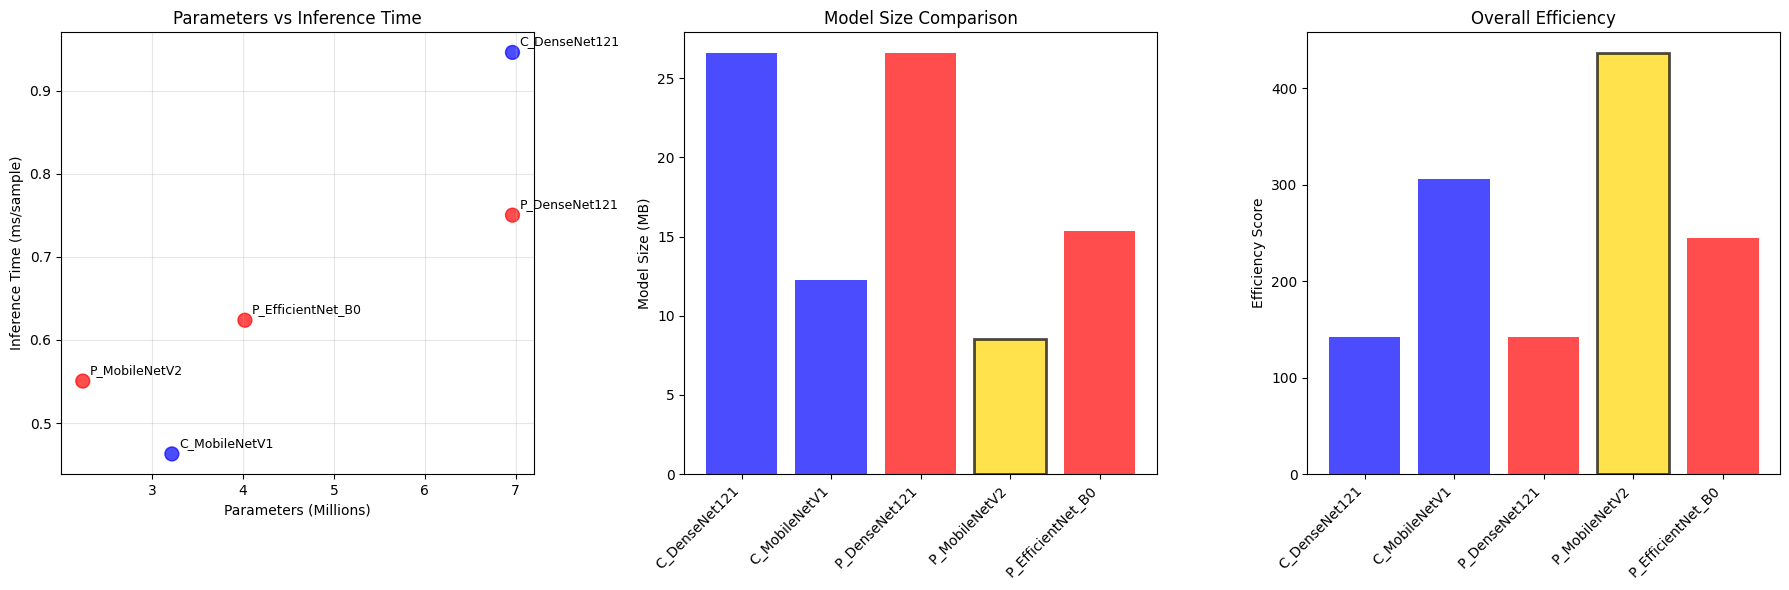


🏆 Most Efficient Model: Pretrained_MobileNetV2
   Efficiency Score: 436.35

📈 2. DenseNet Channel Growth Demo

DENSENET CHANNEL GROWTH DEMONSTRATION
features.denseblock1.layers.0: 44 channels
features.denseblock1.layers.1: 56 channels
features.denseblock1.layers.2: 68 channels
features.denseblock2.layers.0: 46 channels
features.denseblock2.layers.1: 58 channels
features.denseblock2.layers.2: 70 channels
features.denseblock2.layers.3: 82 channels
features.denseblock2.layers.4: 94 channels
features.denseblock2.layers.5: 106 channels


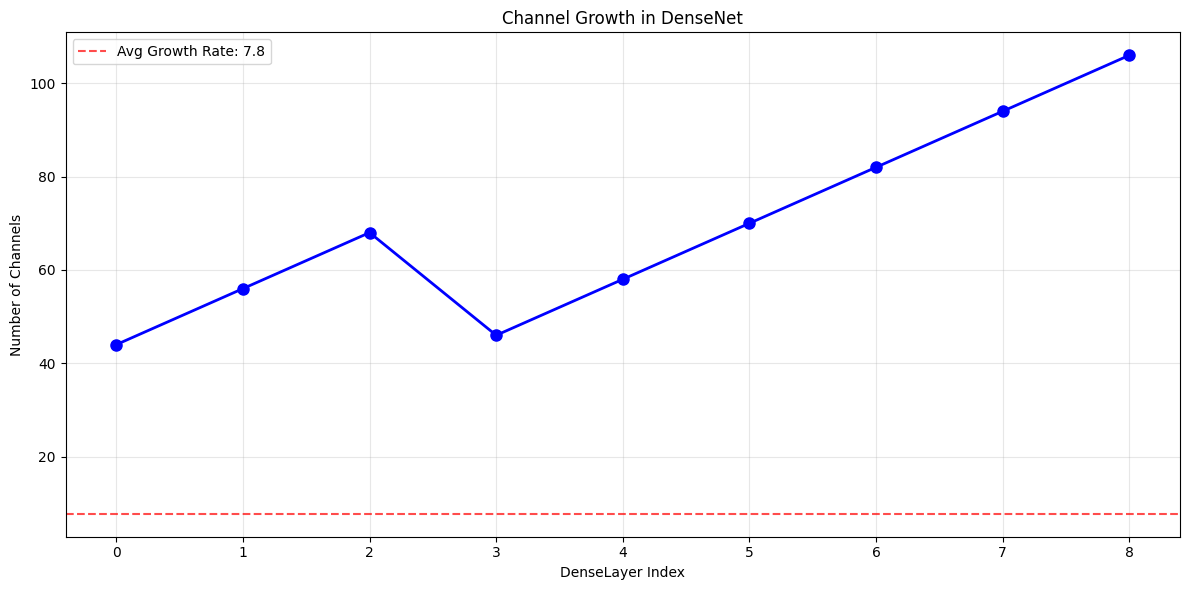


🔍 3. Depthwise Separable Convolution Analysis

DEPTHWISE SEPARABLE CONVOLUTION ANALYSIS
Input Channels: 256
Output Channels: 512
Kernel Size: 3x3

Standard Convolution:
  Parameters: 1,179,648

Depthwise Separable Convolution:
  Depthwise Parameters: 2,304
  Pointwise Parameters: 131,072
  Total Parameters: 133,376

Reduction Factor: 8.84x
Parameter Reduction: 88.7%

Theoretical Formula: 1/N + 1/Dk² = 0.1131
Actual Ratio: 0.1131

✅ 실습 완료!

💡 Key Takeaways:
- DenseNet: Feature reuse through dense connections
- MobileNet: Parameter efficiency through depthwise separable convolutions
- EfficientNet: Balanced scaling for optimal performance
- Each architecture has different trade-offs for different use cases

🎯 다음 단계: 이 구현들을 바탕으로 실제 문제에 적용해보세요!


In [6]:
def main_architecture_comparison():
    """메인 아키텍처 비교 실습"""
    print("Starting CNN Architecture Comparison...")
    
    # 모델 비교 실행
    results, testloader = compare_models()
    
    # 결과 시각화
    plt.figure(figsize=(18, 6))
    
    # 1. Parameters vs Inference Time
    plt.subplot(1, 3, 1)
    names = list(results.keys())
    params = [results[name]['params'] / 1e6 for name in names]  # Millions
    inference_times = [results[name]['inference_time'] for name in names]
    
    colors = ['blue' if 'Custom' in name else 'red' for name in names]
    plt.scatter(params, inference_times, s=100, alpha=0.7, c=colors)
    
    for i, name in enumerate(names):
        short_name = name.replace('Pretrained_', 'P_').replace('Custom_', 'C_')
        plt.annotate(short_name, (params[i], inference_times[i]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    plt.xlabel('Parameters (Millions)')
    plt.ylabel('Inference Time (ms/sample)')
    plt.title('Parameters vs Inference Time')
    plt.grid(True, alpha=0.3)
    
    # 2. Model Size Comparison
    plt.subplot(1, 3, 2)
    sizes = [results[name]['size_mb'] for name in names]
    bars = plt.bar(range(len(names)), sizes, color=colors, alpha=0.7)
    plt.xticks(range(len(names)), [name.replace('Pretrained_', 'P_').replace('Custom_', 'C_') 
                                  for name in names], rotation=45, ha='right')
    plt.ylabel('Model Size (MB)')
    plt.title('Model Size Comparison')
    
    # 가장 작은 모델 강조
    min_idx = np.argmin(sizes)
    bars[min_idx].set_color('gold')
    bars[min_idx].set_edgecolor('black')
    bars[min_idx].set_linewidth(2)
    
    # 3. Efficiency Score
    plt.subplot(1, 3, 3)
    # 효율성 점수: 낮은 파라미터 수와 빠른 추론 시간이 좋음
    efficiency_scores = []
    for name in names:
        param_penalty = results[name]['params'] / 1e6
        time_penalty = results[name]['inference_time']
        # 역수를 취해서 작을수록 좋은 점수
        efficiency = 1000 / (param_penalty + time_penalty / 10)
        efficiency_scores.append(efficiency)
    
    bars = plt.bar(range(len(names)), efficiency_scores, color=colors, alpha=0.7)
    plt.xticks(range(len(names)), [name.replace('Pretrained_', 'P_').replace('Custom_', 'C_') 
                                  for name in names], rotation=45, ha='right')
    plt.ylabel('Efficiency Score')
    plt.title('Overall Efficiency')
    
    # 가장 효율적인 모델 강조
    best_idx = np.argmax(efficiency_scores)
    bars[best_idx].set_color('gold')
    bars[best_idx].set_edgecolor('black')
    bars[best_idx].set_linewidth(2)
    
    plt.tight_layout()
    plt.show()
    
    # 최고 효율 모델 출력
    best_model = names[best_idx]
    print(f"\n🏆 Most Efficient Model: {best_model}")
    print(f"   Efficiency Score: {efficiency_scores[best_idx]:.2f}")
    
    return results

def dense_growth_demo():
    """DenseNet 채널 성장 시각화 데모"""
    print("\n" + "="*60)
    print("DENSENET CHANNEL GROWTH DEMONSTRATION")
    print("="*60)
    
    # 작은 DenseNet 모델 생성 (시각화용)
    demo_model = DenseNet(
        growth_rate=12,  # 작은 growth rate로 변화 관찰
        block_config=(3, 6),  # 2개 블록만
        num_init_features=32,
        num_classes=10
    ).to(device)
    
    # 더미 입력
    dummy_input = torch.randn(1, 3, 32, 32).to(device)
    
    # 채널 성장 시각화
    feature_maps = visualize_dense_growth(demo_model, dummy_input)
    
    return feature_maps

if __name__ == "__main__":
    print("🚀 7일차 오후 실습 시작!")
    print("DenseNet, MobileNet, EfficientNet 아키텍처 비교\n")
    
    # 1. 아키텍처 비교 실습
    print("📊 1. Architecture Comparison")
    results = main_architecture_comparison()
    
    # 2. DenseNet 채널 성장 데모
    print("\n📈 2. DenseNet Channel Growth Demo")
    feature_maps = dense_growth_demo()
    
    # 3. Depthwise Separable Convolution 분석
    print("\n🔍 3. Depthwise Separable Convolution Analysis")
    analyze_depthwise_separable()
    
    print("\n✅ 실습 완료!")
    print("\n💡 Key Takeaways:")
    print("- DenseNet: Feature reuse through dense connections")
    print("- MobileNet: Parameter efficiency through depthwise separable convolutions")
    print("- EfficientNet: Balanced scaling for optimal performance")
    print("- Each architecture has different trade-offs for different use cases")
    
    print("\n🎯 다음 단계: 이 구현들을 바탕으로 실제 문제에 적용해보세요!")

추가 실습 과제

🚀 COMPLETE CNN ARCHITECTURE LAB
📊 Phase 1: Basic Architecture Comparison
Starting CNN Architecture Comparison...
MODEL COMPARISON - Custom Implementations
Files already downloaded and verified
Files already downloaded and verified

Custom_DenseNet121:
  Total Parameters: 6,964,106
  Model Size: 26.57 MB
  Avg Inference Time: 0.64 ms/sample

Custom_MobileNetV1:
  Total Parameters: 3,217,226
  Model Size: 12.27 MB
  Avg Inference Time: 0.40 ms/sample

Pretrained_DenseNet121:
  Total Parameters: 6,964,106
  Model Size: 26.57 MB
  Avg Inference Time: 0.72 ms/sample

Pretrained_MobileNetV2:
  Total Parameters: 2,236,682
  Model Size: 8.53 MB
  Avg Inference Time: 0.11 ms/sample

Pretrained_EfficientNet_B0:
  Total Parameters: 4,020,358
  Model Size: 15.34 MB
  Avg Inference Time: 0.50 ms/sample


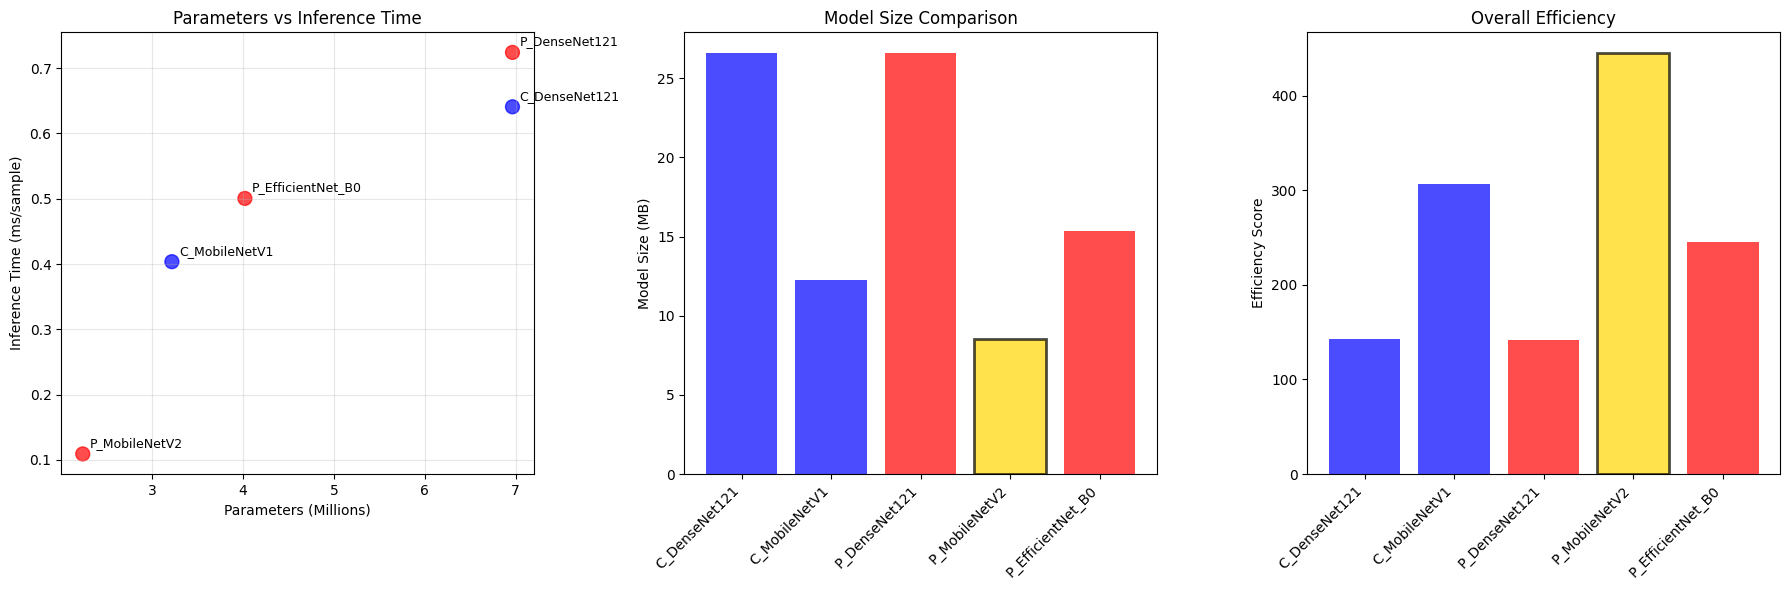


🏆 Most Efficient Model: Pretrained_MobileNetV2
   Efficiency Score: 444.92

📈 Phase 2: DenseNet Analysis

DENSENET CHANNEL GROWTH DEMONSTRATION
features.denseblock1.layers.0: 44 channels
features.denseblock1.layers.1: 56 channels
features.denseblock1.layers.2: 68 channels
features.denseblock2.layers.0: 46 channels
features.denseblock2.layers.1: 58 channels
features.denseblock2.layers.2: 70 channels
features.denseblock2.layers.3: 82 channels
features.denseblock2.layers.4: 94 channels
features.denseblock2.layers.5: 106 channels


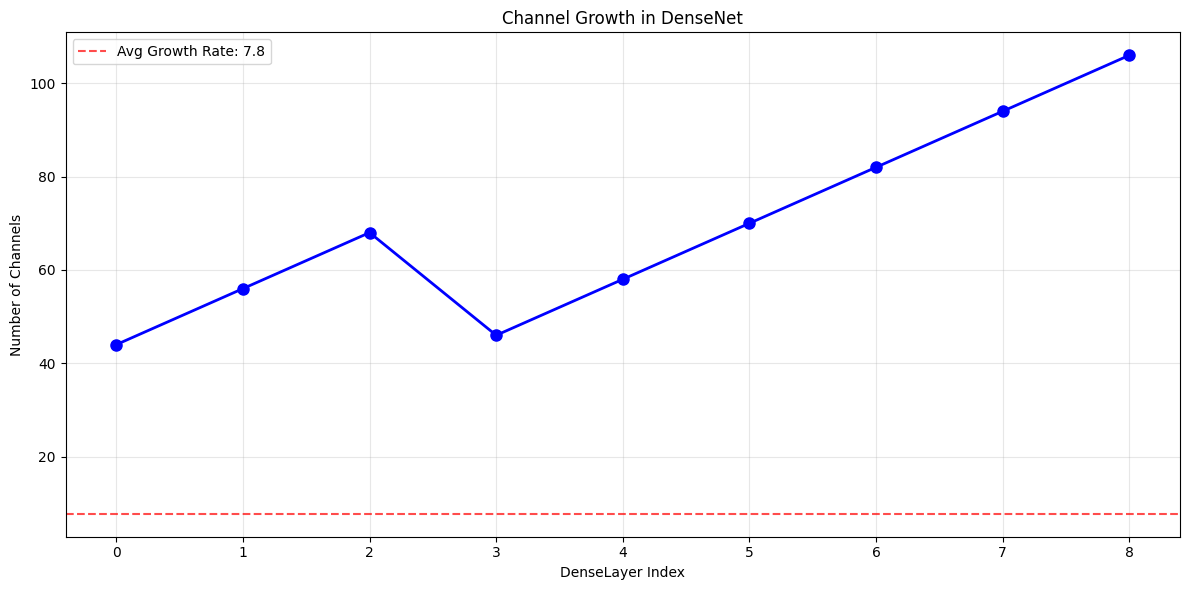


🔍 Phase 3: MobileNet Analysis

DEPTHWISE SEPARABLE CONVOLUTION ANALYSIS
Input Channels: 256
Output Channels: 512
Kernel Size: 3x3

Standard Convolution:
  Parameters: 1,179,648

Depthwise Separable Convolution:
  Depthwise Parameters: 2,304
  Pointwise Parameters: 131,072
  Total Parameters: 133,376

Reduction Factor: 8.84x
Parameter Reduction: 88.7%

Theoretical Formula: 1/N + 1/Dk² = 0.1131
Actual Ratio: 0.1131

🔬 Phase 4: Extended Experiments

🔬 EXTENDED EXPERIMENTS

1. Growth Rate Experiment
Growth Rate 12: 225,250 parameters
Growth Rate 24: 763,450 parameters
Growth Rate 32: 1,303,690 parameters
Growth Rate 48: 2,819,626 parameters

2. Width Multiplier Experiment

MOBILENET WIDTH MULTIPLIER EXPERIMENT
Width Multiplier 0.25: 215,642 parameters (0.82 MB)
Width Multiplier 0.5: 823,722 parameters (3.14 MB)
Width Multiplier 0.75: 1,824,250 parameters (6.96 MB)
Width Multiplier 1.0: 3,217,226 parameters (12.27 MB)
Width Multiplier 1.25: 5,002,650 parameters (19.08 MB)

3. Model Compres

In [7]:
# 과제 1: DenseNet에서 growth rate를 바꿔가며 성능 비교
def growth_rate_experiment():
    """Growth rate 변화에 따른 성능 비교"""
    growth_rates = [12, 24, 32, 48]
    
    for gr in growth_rates:
        model = DenseNet(growth_rate=gr, block_config=(6, 12), num_classes=10)
        params = count_parameters(model)
        print(f"Growth Rate {gr}: {params:,} parameters")

# 과제 2: MobileNet width multiplier 실험  
def width_multiplier_experiment():
    """Width multiplier 변화에 따른 성능 비교"""
    width_multipliers = [0.25, 0.5, 0.75, 1.0, 1.25]
    
    print("\n" + "="*60)
    print("MOBILENET WIDTH MULTIPLIER EXPERIMENT")
    print("="*60)
    
    for wm in width_multipliers:
        model = MobileNet(num_classes=10, width_multiplier=wm)
        params = count_parameters(model)
        size_mb = params * 4 / (1024 * 1024)
        
        print(f"Width Multiplier {wm}: {params:,} parameters ({size_mb:.2f} MB)")

# 과제 3: 커스텀 하이브리드 모델
class DenseMobileNet(nn.Module):
    """DenseNet + MobileNet 하이브리드 모델"""
    def __init__(self, num_classes=10):
        super(DenseMobileNet, self).__init__()
        
        # 초기 특징 추출 (MobileNet 스타일)
        self.initial_conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        
        # Dense connection 부분
        self.dense_block = DenseBlock(
            num_layers=6, 
            in_channels=32, 
            growth_rate=16,  # 작은 growth rate
            drop_rate=0.1
        )
        
        # Depthwise separable convolutions
        self.ds_conv1 = DepthwiseSeparableConv(32 + 6*16, 256, stride=2)
        self.ds_conv2 = DepthwiseSeparableConv(256, 512, stride=2)
        
        # Global average pooling
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Linear(512, num_classes)
        
    def forward(self, x):
        # 초기 특징 추출
        x = self.initial_conv(x)
        
        # Dense connection으로 특징 재사용
        x = self.dense_block(x)
        
        # Efficient convolution
        x = self.ds_conv1(x)
        x = self.ds_conv2(x)
        
        # 분류
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        
        return x

# 과제 4: Feature Map 시각화
def visualize_feature_maps(model, data_loader, layer_name='features.denseblock1'):
    """특정 레이어의 feature map 시각화"""
    model.eval()
    
    # 첫 번째 배치 가져오기
    inputs, labels = next(iter(data_loader))
    inputs = inputs[:4].to(device)  # 4개 샘플만
    
    # Hook으로 중간 feature map 캡처
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook
    
    # 특정 레이어에 hook 등록
    layer = dict(model.named_modules())[layer_name]
    hook = layer.register_forward_hook(get_activation(layer_name))
    
    # Forward pass
    with torch.no_grad():
        _ = model(inputs)
    
    # Feature map 시각화
    feature_map = activation[layer_name]
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    for i in range(4):
        # 원본 이미지
        img = inputs[i].cpu()
        img = (img - img.min()) / (img.max() - img.min())  # 정규화
        axes[0, i].imshow(img.permute(1, 2, 0))
        axes[0, i].set_title(f'Input Image {i+1}')
        axes[0, i].axis('off')
        
        # Feature map (첫 번째 채널)
        fmap = feature_map[i, 0].cpu().numpy()
        axes[1, i].imshow(fmap, cmap='viridis')
        axes[1, i].set_title(f'Feature Map {i+1}')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Hook 제거
    hook.remove()
    
    return activation

# 과제 5: 모델 압축 실험
def model_compression_demo():
    """모델 압축 기법 데모"""
    print("\n" + "="*60)
    print("MODEL COMPRESSION DEMONSTRATION")
    print("="*60)
    
    # 원본 모델
    original_model = DenseNet121(num_classes=10)
    original_params = count_parameters(original_model)
    
    print(f"Original Model: {original_params:,} parameters")
    
    # 1. Pruning 시뮬레이션 (간단한 magnitude-based pruning)
    def simple_pruning(model, pruning_ratio=0.2):
        """간단한 magnitude-based pruning"""
        model_copy = DenseNet121(num_classes=10)
        model_copy.load_state_dict(model.state_dict())
        
        # 각 Conv layer에서 작은 가중치 제거
        for module in model_copy.modules():
            if isinstance(module, nn.Conv2d):
                weight = module.weight.data
                threshold = torch.quantile(torch.abs(weight), pruning_ratio)
                mask = torch.abs(weight) > threshold
                module.weight.data *= mask.float()
        
        return model_copy
    
    # 2. Quantization 시뮬레이션
    def simulate_quantization(model, bits=8):
        """8-bit quantization 시뮬레이션"""
        model_copy = DenseNet121(num_classes=10)
        model_copy.load_state_dict(model.state_dict())
        
        # 가중치를 8-bit로 양자화
        for module in model_copy.modules():
            if isinstance(module, (nn.Conv2d, nn.Linear)):
                weight = module.weight.data
                
                # Min-max quantization
                w_min, w_max = weight.min(), weight.max()
                scale = (w_max - w_min) / (2**bits - 1)
                quantized_weight = torch.round((weight - w_min) / scale) * scale + w_min
                module.weight.data = quantized_weight
        
        return model_copy
    
    # 압축 기법 적용
    pruned_model = simple_pruning(original_model, pruning_ratio=0.3)
    quantized_model = simulate_quantization(original_model, bits=8)
    
    # 압축된 모델의 "effective" 파라미터 수 계산
    def count_nonzero_params(model):
        return sum((p != 0).sum().item() for p in model.parameters())
    
    pruned_params = count_nonzero_params(pruned_model)
    
    print(f"Pruned Model (30%): {pruned_params:,} parameters "
          f"({(1-pruned_params/original_params)*100:.1f}% reduction)")
    print(f"Quantized Model (8-bit): ~{original_params//4:,} effective parameters "
          f"(~75% size reduction)")
    
    return original_model, pruned_model, quantized_model

# 과제 6: 실시간 성능 모니터링
def real_time_performance_monitor():
    """실시간 성능 모니터링"""
    print("\n" + "="*60)
    print("REAL-TIME PERFORMANCE MONITORING")
    print("="*60)
    
    # 데이터 로더
    _, testloader, _ = get_data_loaders(batch_size=32)
    
    # 모델들
    models_to_test = {
        'DenseNet121': DenseNet121(num_classes=10).to(device),
        'MobileNetV1': MobileNet(num_classes=10).to(device),
        'HybridModel': DenseMobileNet(num_classes=10).to(device)
    }
    
    # 성능 측정
    performance_data = {}
    
    for name, model in models_to_test.items():
        model.eval()
        
        # GPU 메모리 사용량 측정 (CUDA 사용 시)
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.reset_peak_memory_stats()
        
        # 추론 시간과 메모리 사용량 측정
        times = []
        with torch.no_grad():
            for i, (inputs, _) in enumerate(testloader):
                if i >= 5:  # 5 배치만 테스트
                    break
                
                inputs = inputs.to(device)
                
                if torch.cuda.is_available():
                    torch.cuda.synchronize()
                    start_time = time.time()
                
                _ = model(inputs)
                
                if torch.cuda.is_available():
                    torch.cuda.synchronize()
                    end_time = time.time()
                    times.append((end_time - start_time) * 1000)
        
        avg_time = np.mean(times)
        std_time = np.std(times)
        
        # 메모리 사용량
        if torch.cuda.is_available():
            memory_used = torch.cuda.max_memory_allocated() / 1024**2  # MB
        else:
            memory_used = 0
        
        performance_data[name] = {
            'avg_time': avg_time,
            'std_time': std_time,
            'memory_mb': memory_used,
            'params': count_parameters(model)
        }
        
        print(f"{name}:")
        print(f"  Avg Time: {avg_time:.2f} ± {std_time:.2f} ms")
        print(f"  Memory: {memory_used:.1f} MB")
        print(f"  Parameters: {count_parameters(model):,}")
        print()
    
    return performance_data

# 과제 7: 아키텍처 최적화 실험
def architecture_optimization_experiment():
    """아키텍처 최적화 실험"""
    print("\n" + "="*60)
    print("ARCHITECTURE OPTIMIZATION EXPERIMENT")
    print("="*60)
    
    # 다양한 설정으로 DenseNet 실험
    configs = [
        {'growth_rate': 12, 'block_config': (6, 12, 24, 16), 'name': 'DenseNet121_Small'},
        {'growth_rate': 32, 'block_config': (6, 12, 24, 16), 'name': 'DenseNet121_Standard'},
        {'growth_rate': 48, 'block_config': (6, 12, 24, 16), 'name': 'DenseNet121_Large'},
        {'growth_rate': 32, 'block_config': (6, 12, 18, 12), 'name': 'DenseNet_Custom'},
    ]
    
    # MobileNet 설정들
    mobile_configs = [
        {'width_multiplier': 0.5, 'name': 'MobileNet_0.5x'},
        {'width_multiplier': 1.0, 'name': 'MobileNet_1.0x'},
        {'width_multiplier': 1.25, 'name': 'MobileNet_1.25x'},
    ]
    
    print("DenseNet Configurations:")
    for config in configs:
        model = DenseNet(
            growth_rate=config['growth_rate'],
            block_config=config['block_config'],
            num_classes=10
        )
        params = count_parameters(model)
        size_mb = params * 4 / (1024 * 1024)
        
        print(f"  {config['name']}: {params:,} params ({size_mb:.2f} MB)")
    
    print("\nMobileNet Configurations:")
    for config in mobile_configs:
        model = MobileNet(
            num_classes=10,
            width_multiplier=config['width_multiplier']
        )
        params = count_parameters(model)
        size_mb = params * 4 / (1024 * 1024)
        
        print(f"  {config['name']}: {params:,} params ({size_mb:.2f} MB)")

# 메인 실행부 확장
def extended_experiments():
    """확장 실험들"""
    print("\n🔬 EXTENDED EXPERIMENTS")
    
    # 1. Growth rate 실험
    print("\n1. Growth Rate Experiment")
    growth_rate_experiment()
    
    # 2. Width multiplier 실험  
    print("\n2. Width Multiplier Experiment")
    width_multiplier_experiment()
    
    # 3. 모델 압축 데모
    print("\n3. Model Compression Demo")
    original, pruned, quantized = model_compression_demo()
    
    # 4. 성능 모니터링
    print("\n4. Real-time Performance Monitoring")
    perf_data = real_time_performance_monitor()
    
    # 5. 아키텍처 최적화
    print("\n5. Architecture Optimization")
    architecture_optimization_experiment()
    
    return perf_data

# 최종 통합 실행 함수
def run_complete_lab():
    """완전한 실습 실행"""
    print("🚀 COMPLETE CNN ARCHITECTURE LAB")
    print("="*80)
    
    try:
        # 기본 실습
        print("📊 Phase 1: Basic Architecture Comparison")
        results = main_architecture_comparison()
        
        print("\n📈 Phase 2: DenseNet Analysis")
        feature_maps = dense_growth_demo()
        
        print("\n🔍 Phase 3: MobileNet Analysis")
        analyze_depthwise_separable()
        
        print("\n🔬 Phase 4: Extended Experiments")
        perf_data = extended_experiments()
        
        print("\n✅ ALL EXPERIMENTS COMPLETED SUCCESSFULLY!")
        
        # 최종 요약
        print("\n" + "="*60)
        print("FINAL SUMMARY")
        print("="*60)
        print("✅ DenseNet: Feature reuse through dense connections")
        print("✅ MobileNet: Efficiency through depthwise separable convolutions") 
        print("✅ Hybrid Models: Combining strengths of different architectures")
        print("✅ Compression: Pruning and quantization for deployment")
        print("✅ Performance: Trade-offs between accuracy, speed, and size")
        
        return results, feature_maps, perf_data
        
    except Exception as e:
        print(f"❌ Error during execution: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

if __name__ == "__main__":
    # 전체 실습 실행
    results, feature_maps, perf_data = run_complete_lab()
    
    print("\n🎯 NEXT STEPS:")
    print("1. 실제 데이터셋으로 모델 훈련해보기")
    print("2. 하이브리드 모델 설계 및 실험")
    print("3. 모델 압축 기법 심화 학습")
    print("4. 실시간 추론 시스템 구축")
    print("5. AutoML을 통한 아키텍처 자동 탐색")
    
    print("\n🏆 실습 완료! 수고하셨습니다!")

# 추가 유틸리티 함수들
def save_model_comparison(results, filename='model_comparison.txt'):
    """모델 비교 결과 저장"""
    with open(filename, 'w') as f:
        f.write("CNN Architecture Comparison Results\n")
        f.write("="*50 + "\n\n")
        
        for name, data in results.items():
            f.write(f"{name}:\n")
            f.write(f"  Parameters: {data['params']:,}\n")
            f.write(f"  Size: {data['size_mb']:.2f} MB\n")
            f.write(f"  Inference Time: {data['inference_time']:.2f} ms\n\n")
    
    print(f"Results saved to {filename}")

def load_pretrained_and_compare():
    """사전훈련된 모델과 커스텀 모델 정확도 비교"""
    print("Loading pretrained models for accuracy comparison...")
    
    # 이 함수는 실제 훈련된 모델이 있을 때 사용
    # 현재는 구조 비교만 수행
    pass